In [1]:
# ! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from fastai.vision.all import *

# Computer Vision - Multi-Label Classification

Multi-label classification refers to the problem when you want to predict more than one label per image (or sometimes none at all).

This would have been a great approach for our bear classifier, where if a user uploaded something that wasn't any kind of bear, the model would still stay it was either a grizzly, black or teddy bear - it had zero ability to predict "not a bear at all". After we complete this chapter, it would be a great excercise to go back to the bear classifier application and retrain it using the multi-label technique, then test it by passing in an image that is not of any of your recognised clases.

## The Data

Let's see what a multi-label dataset looks like, then we'll explain how to get it ready for our model. You'll see that the architecture of the model does not change from the last chapter; only the loss function does.

We'll use the PASCAL dataset, which can have more than one kind of classified object per image.
We begin by downloading and extracting the dataset as per usual.

In [3]:
path = untar_data(URLs.PASCAL_2007)

This dataset is different from the ones we have seen before, in that it is not structured by filename or folder but instead comes with a CSV file telling us what labels to use for each image.
We can inspect the CSV file by reading it into a Pandas DataFrame.

In [4]:
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


## Constructing a DataBlock

In fastai, it is recommended to use the data block API for creating a `DataLoaders` object, where possible, since it provides a good mix of flexibility and simplicity.
Using the above dataset as an example, we will use the data blocks API to construct a `DataLoaders` object.

PyTorch and fastai hae two main classes for representing and accessing a training set or validation set:
- `Dataset`: A collection that returns a tuple for your independent and dependent variable for a single item.
- `DataLoader`: An iterator that provides a stream of mini-batches, where each mini-batch is a tuple of a batch of independent variables and a batch of dependent variables.

On top of these, fastai provides two classes for bringing your training and validation sets together:
- `Datasets`: An object that contains a `training Dataset` and a `validation Dataset`.
- `DataLoaders`: An object that contains a `training DataLoader` and a `validation DataLoader`.

Since `DataLoader` builds on top of a `Dataset` and adds functionality to it (collating multiple items into a mini-batch), it's often easiest to start by creating and testing `Datasets`, and then look at `DataLoaders` after tat's working.




When we create a `DataBlock`, we build up gradually step by step, and use the notebook to check our data along the way.

Let's start with the simplest case, which is a data block created with no parameters.

In [5]:
dblock = DataBlock()

When we create a `Datasets` object from this, the only thing needed is a source - in this case, our Pandas DataFrame.

In [6]:
dsets = dblock.datasets(df)

This contains a `train` and a `valid` dataset, which we can index into.

In [7]:
len(dsets.train), len(dsets.valid)

(4009, 1002)

In [8]:
x,y = dsets.train[0]
x,y

(fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object,
 fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object)

As you can see, this simply returns a row of the DataFrame twice. This is because by default, the data block assumes we have two things: input and target.

We are going to need to grab the appropriate fields from the DataFrame, which we can do by passing `get_x` and `get_y` functions into the `DataBlock`.

In [9]:
dblock = DataBlock(get_x = lambda r: r["fname"],
                   get_y = lambda r: r["labels"])

dsets = dblock.datasets(df)
dsets.train[0]

('005620.jpg', 'aeroplane')

As you can see, rather than defining a function in the usual way, we are using Python's `lambda` keyword. This is a shortcut for defining and then referring to a function.
Lambda functions are great for quickly iterating, but they are not compatible with **serialization**, so it is advised to use the more verbose approach if you want to export your `Learner` after training.

The following is the more verbose approach.

In [10]:
def get_x(r): return r["fname"]
def get_y(r): return r["labels"]

dblock = DataBlock(get_x = get_x,
                    get_y = get_y)

dsets = dblock.datasets(df)
dsets.train[0]

('002549.jpg', 'tvmonitor')

We can see that the independent variable will need to be converted into a complete path, so that we can open it as an image, and the dependent variable will need to be split on the space character so that it becomes a list.

In [11]:
def get_x(r): return path/'train'/r["fname"]
def get_y(r): return r["labels"].split(' ')

dblock = DataBlock(get_x = get_x,
                    get_y = get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(Path('/Users/286329i/.fastai/data/pascal_2007/train/002844.jpg'), ['train'])

To actually open the image and do the conversion to tensors, we will need to use a set of transforms; block types will provide us with those.

We can use the same block types that we have used previously, with one exception: the `ImageBlock` will work fine again, because we have a path that points to a valid image, but the `CategoryBlock` is not going to work. The problem is that block returns a single integer, but we need to be able to have multiple labels for each item. To solve this, we use a `MultiCategoryBlock`. This type of block expects to receive a list of strings, as we have in this case, so let's test it out.

In [12]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x,
                   get_y = get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]))

As you can see, our list of categories is not encoded in the same way that it was for the regular `CategoryBlock`. In that case, we had a single integer representing which category was present, based on its location in our vocabluary. In this case, however, we instead have a list of zeros, with a one in any postion where that category is present.

For example, if there is a one in the second and fourth positions, then that means that vocab items two and four are present in this image. This is known as *one-hot encoding*. The reason we can't easily just use a list of category indices is that each list would be a different length, and PyTorch requires tensors, where everything has to be the same length.

Let's check what the categories represent for this example (we are using the convenient `torch.where` function, which tells us all of the indices where our condition is true or false).

In [13]:
idxs = torch.where(dsets.train[0][1] == 1.)[0]
dsets.train.vocab[idxs]

(#1) ['dog']

With NumPy arrays, PyTorch tensors and fastai's `L` class, we can index directly using a list or a vector, which makes a lot of code much clearer and more concise.

We have ignored the `is_valid` column of our DataFrame up until now, which means that our `DataBlock` has been using a random split by default. To explicitly choose the elements of our validation set, we need to write a function and pass it to `splitter`. It will take the items (here our whole DataFrame) and must return two (or more) lists of integers.

In [14]:
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train, valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                    splitter = splitter,
                    get_x = get_x,
                    get_y = get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

As we have discussed, a `DataLoader` collates the items from a `Dataset` into a mini-batch. This is a tuple of tensors, where each tensor simply stacks the items from that location in the `Dataset` item.

Now that we have confirmed that the individual items look away, there's one more step we need to ensure we can create our `DataLoaders`, which is to ensure that every item is of the same size.

To do this, we can use `RandomResizedCrop`.

In [15]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                    splitter = splitter,
                    get_x = get_x,
                    get_y = get_y,
                    item_tfms = RandomResizedCrop(128, min_scale=0.35))

dls = dblock.dataloaders(df)

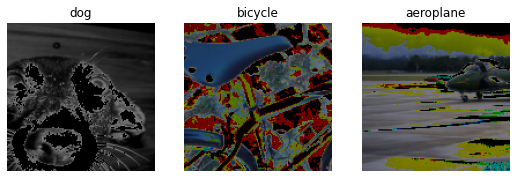

In [16]:
dls.show_batch(nrows=1, ncols=3)

Remember that, if anything goes wrong when you create your `DataLoaders` from your `DataBlock`, or if you want to view exactly what happens with your `DataBlock`, you can use the summary method we presented in the last chapter.

Our data is now ready for training a model. As we will see, nothing is going to change when we create our `Learner`, but behind the scenes, the fastai library will pick a new loss function for us: binary cross-entropy.

## Binary Cross-Entropy

We'll now create our `Learner`. Remember that a `Learner` object contains four main things: the model, a `DataLoaders` object, an `Optimizer`, and the loss function to use.
We already have our `DataLoaders`, we can leverage fastai's `resnet` models, and we know how to create an `SGD` optimizer. So let's focus on ensuring that we have a suitable loss function.

To do this, let's use `vision_learner` to create a `Learner`, so we can look at its activations.


In [17]:
learn = vision_learner(dls, resnet18)

/Users/286329i/miniforge3/envs/fastai_mps/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  warnings.warn(
/Users/286329i/miniforge3/envs/fastai_mps/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


We also saw that the model in a `Learner` is generally an object of a class inheriting from `nn.Module`, and that we can call it use parentheses and it will return the activations of a model. You should pass it your independent variable, as a mini-batch. We can try it out by grabbing a mini-batch from our `DataLoader` and then passing it to the model.

In [18]:
x,y = to_cpu(dls.train.one_batch())
activs = learn.model(x)
activs.shape

torch.Size([64, 20])

The reason why `activs` has the above shape is that we have a batch size of 64, and we need to calculate the probability of each of the 20 categories. Here is what one of those activations looks like.

In [19]:
activs[0]

TensorBase([-4.2078, -3.4737, -1.4975, -2.4905, -4.6132, -2.5583,  0.3214, -5.3483, -4.0027, -4.2735,  6.8368, -3.4636,  1.0744,  7.7330, -0.7665,  2.1159,  0.3225,  5.1301,  0.8251, -2.4551],
           grad_fn=<AliasBackward0>)

These activations are not yet scaled to between 0 and 1, but we learned how to do that previously using the `sigmoid` function. We also saw how to calculate a loss based on this.

In [20]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

Note that because we have a one-hot-encoded dependent variable, we can't directly use `nll_loss` or `softmax` (and therefore we can't use `cross_entroy`):
- `softmax`, requires that all predictions sum to 1, and tends to push one activation to be much larger than the others; however, we may well have multiple objects that we're confident appear in an image, so restricting the maximum sum of activations to 1 is not a good idea. By the same reasoning, we may want the sum to be less than 1, if we don't think any of the categories appear in an image.
- `nll_loss`, returns the value of just one activation, the single activation corresponding with the single label for an item. This doesn't make sense when we have multiple labels.

On the otherhand, the `binary_cross_entropy` function, which is just `mnist_loss` along with `log`, provides just what we need, thanks to the magic of PyTorch's elementwise operations. Each activation will be compared to each target for each column, so we don't have to do anything to make this function work for multiple columns. 

PyTorch already provides this function fo us. In fact, it provides a number of versions, with rather confusing names.

`F.binary_cross_entropy` and its module equivalent `nn.BCELoss` calculate cross-entropy on a one-hot-encoded target, but do not include the initial `sigmoid`.

Normally for one-hot-encoded targets, you'll want `F.binary_cross_entropy_with_logits` (or `nn.BCEWithLogitsLoss`), which do both sigmoid and binary cross-entropy in a single function.

The equivalent for single-label datasets, where the target is encoded as a single integer, is `F.nll_loss` or `nn.NLLLoss` for the version without the initial softmax, and `F.cross_entropy` or `nn.CrossEntropyLoss` for the version with the initial softmax.

Since we have a one-hot-encoded target, we will use `BCEWithLogitsLoss`.

In [21]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorMultiCategory(1.1049, grad_fn=<AliasBackward0>)

We don't actually need to tell fastai to use this loss function (although we can), since it will be automatically be chosen for us. fastai knows that the `DataLoaders` has multiple category labels, so it will use `nn.BCEWithLogitsLoss` by default.

## Metrics
One change compared to the last chapter is the metric we use: because this is a multilabel problem, we can't use the accuracy function. This is because accuracy was comparing our outputs to our targets like so:

In [22]:
def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred = inp.argmax(dim=axis)
    return (pred == targ).float().mean()

The class predicted was the one with the highest activation. Here, it doesn't work because we could have more than one prediction on a single image. After applying the sigmoid to our activations, we need to decide which ones are 0s and which ones are 1s by picking a *threshold*. Each value above the threshold will be considered as a 1, and each value lower than the threshold will be considered a 0.

In [23]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size"
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

If we pass `accuracy_multi` directly as a metric, it will use the default value for `threshold`, which is 0.5. We might want to adjust that default and create a new version of `accuracy_multi` that has a different default. To help with this, there is a function in Python called `partial`. It allows us to bind a function with some arguments, making a new version of that function that, whenever is called, always includes those arguments.

We can now train our model. Let's try setting the accuracy threshold to 0.2 for our metric.

In [24]:
learn = vision_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

/Users/286329i/miniforge3/envs/fastai_mps/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.978164,0.732083,0.176693,00:56
1,0.883428,0.624955,0.213765,00:56
2,0.668156,0.259519,0.753267,00:47
3,0.430009,0.191665,0.908725,00:43


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.207711,0.296073,0.820239,00:58
1,0.188536,0.310982,0.814642,01:00
2,0.165174,0.297480,0.810976,01:05


Picking a threshold is important. If you pick a threshold that is too low, you'll often be failing to select correctly labeled objects. We can see this by changing our metric, and then calling `validate` which returns the validation loss and metrics.

In [25]:
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()

(#2) [0.29748043417930603,0.7468924522399902]

If you pick a threshold that is too high, you'll only be selecting the objects for which your model is very confident.

In [26]:
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate()

(#2) [0.29748043417930603,0.9389243125915527]

We can find the **best threshold** by trying a few levels and seeing what works best. This is much faster if we just grab the predictions once.

In [27]:
preds,targs = learn.get_preds()

Then we can call the metric directly. Note that by default `get_preds` applies the output activation function (sigmoid, in this case) for us, so we'll need to tell `accuracy_multi` to not apply it.

In [28]:
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

TensorBase(0.9337)

We can now use this approach to find the best threshold level.

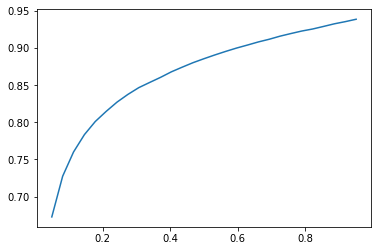

In [29]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs, accs);

In this case, we're using the validation set to pick a hyperparameter (the threshold), which is the purpose of the validation set. This does not result in overfitting to the validation set as changing the threshold results in a smooth curve, we we're clearly not picking some inappropriate outliet.